<a href="https://colab.research.google.com/github/maticvl/dataHacker/blob/master/pyTorch/011_alexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# History
Hi, and welcome back. In today's tutorial we will talk about a popular convolutional network. We will talk about AlexNet. 

It was designed by Alex Krizhevsky and published by Ilya sutskever and Geoffrey Hinton. 

It is popular because of it's high performance back in 2012, when it achieved a top-5 error rate of 15.3% on the ImageNet dataset. The next best result was 26.2% which is far behind this network.

# How does it work ?

It takes as input a 3 channel image, or a color image and returns a probability to which class that image belongs to.

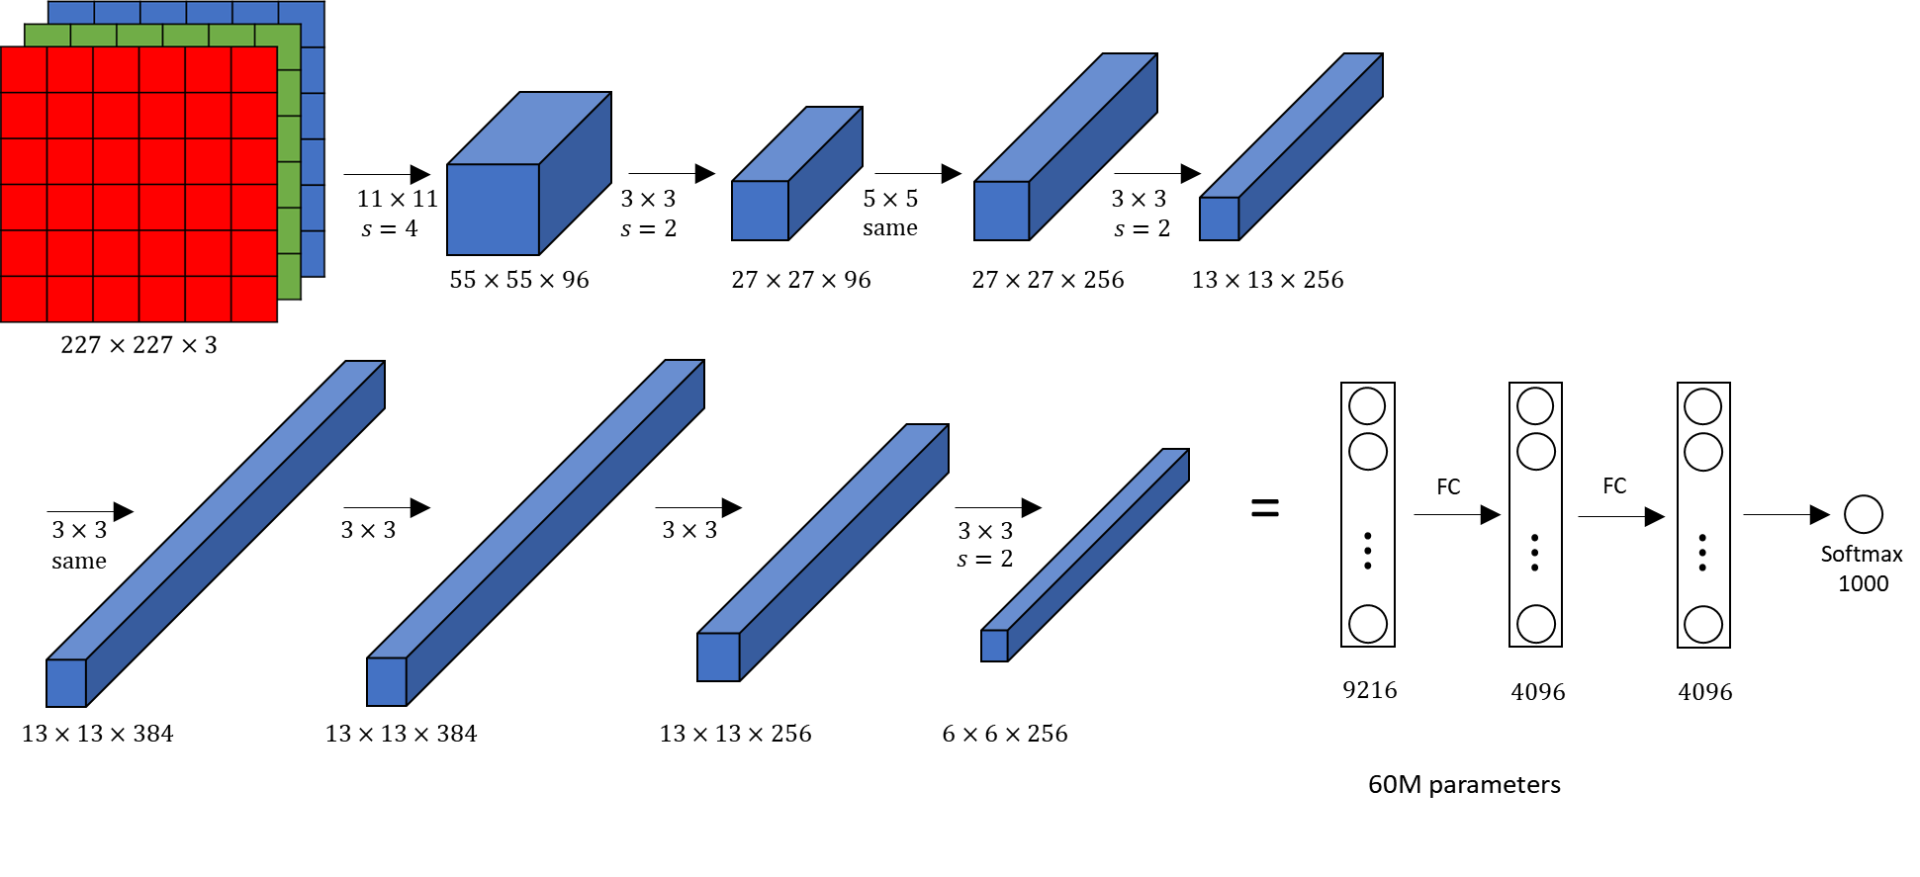

First, we apply a convolution with filter size of 11 and 96 filters. We also use a stride of 4 that will dicrease the dimensions of the the input by a factor of 4, so we have an output of shape 55x55x96.

The next layer is a max pooling layer, and it uses a 3x3 filter and a stride of 2. And this layer outputs a shape of 27x27x96.

Now, it just repeats these two layers, we have a convolutional, returning a shape of 27x27x256 and then a max pool layer, returning 13x13x256.

And after that it applies 3 convolutional layers, with the same parameters. The number of filters for the first two will be 384, and for the last one 256 filters.

When these convolutions are applied, it moves over to do a max pooling layer which returns a shape of 6x6x256. Which is 9216 nodes.

After that, it moves on to the fully connected layers, applying three layers, the first two layers have 4096 nodes, where the third returns the same amount of units as the amount of classes it has. It applies a softmax function to the output of this layer, and it outputs which one of the 1000 classes the object could be.


# Differences from other networks
It is similar to LetNet, but much larger. LeNet-5 has about 60000 paramters, which alexnet has about 60 million paramters, which is a big number of paramters to be learned.

But, there are some changes that made AlexNet differ from other networks back in the time.

## Overlapping pooling layers

Standard pooling layers are summarizing the ouputs of neighboring groups of neurons in the same kernel map. Traditionally, the neigborhoods summarized by adjacent pooling units do not overlap. 

Overlapping pooling layers are similar to the standard pooling layers, exept the adjacent windows over which the Max is computer overlap each other

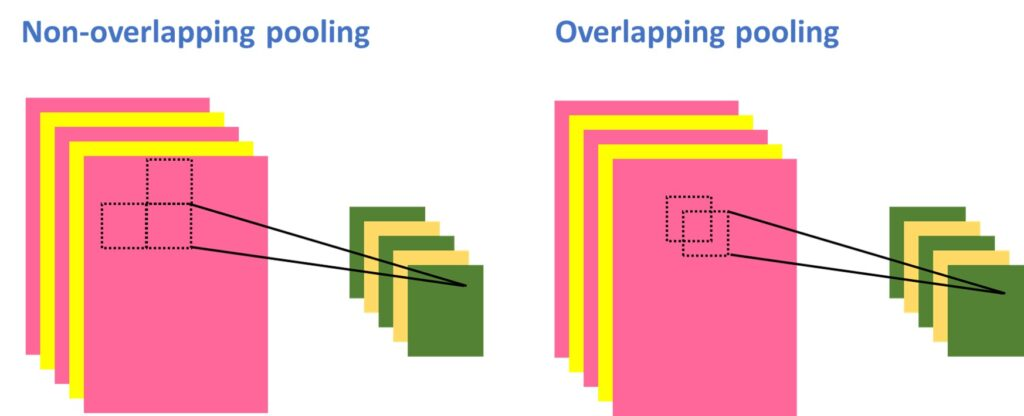

## ReLU nonlinearity

A traditional way to evaluate a neuron output is using sigmoid or tanh activation function. These two functions are fixed between min and max value, so they are saturating nonlinear. However, in AlexNet, the authors used Rectified linear unit function. This function has a threshold at 0. This is a nonsaturating activation function.

ReLU function requires less computation and allows faster learning, which has a great influence on the performance of large models trained on large datasets.

# Code

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
from torchvision import datasets, transforms

import zipfile

import shutil
import os
import pandas as pd

device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 2):
        super(AlexNet, self).__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.linear = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.convolutional(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return torch.softmax(x, 1)


In [ ]:
model = AlexNet()
model = model.to(device)

In [ ]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

--2021-03-17 18:22:41--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.117.16
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.117.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  77.3MB/s    in 18s     

2021-03-17 18:22:59 (74.8 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [ ]:
with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [ ]:
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [ ]:
df = pd.read_csv("list_attr_celeba.csv")
df = df[['image_id', 'Smiling']]

In [ ]:
!rm -rf data
!mkdir data && mkdir data/smile && mkdir data/no_smile

In [ ]:
s0 = 0
s1 = 0

num = 1500

for i, (_, i_row) in enumerate(df.iterrows()):
  if s0 < num:
    if i_row['Smiling'] == 1:
      s0 += 1
      shutil.copyfile('data_faces/img_align_celeba/' + i_row['image_id'], 'data/smile/' + i_row['image_id'])
  
  if s1 < num:
    if i_row['Smiling'] == -1:
      s1 += 1
      shutil.copyfile('data_faces/img_align_celeba/' + i_row['image_id'], 'data/no_smile/' + i_row['image_id'])
  
  if s0 == num and s1 == num:
    break

In [ ]:
img_list = os.listdir('data/smile/')
img_list.extend(os.listdir('data/no_smile/'))

In [ ]:
print("Images: ", len(img_list))

Images:  3000


In [ ]:
!rm -rf 'data/.ipynb_checkpoints/'

In [ ]:
transform = transforms.Compose([
          transforms.Resize((64, 64)),
          transforms.ToTensor()
          ])

batch_size = 64
celeba_data = datasets.ImageFolder('data', transform=transform)

In [ ]:
print(celeba_data.classes)
print(len(celeba_data))

['no_smile', 'smile']
3000


In [ ]:
train_set, test_set = torch.utils.data.random_split(celeba_data, [int(len(img_list) * 0.75), len(img_list) - int(len(img_list) * 0.75)])
train_data_size = len(train_set)
test_data_size = len(test_set)

In [ ]:
trainLoader = torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True)
testLoader  = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [ ]:
print(train_data_size)
print(test_data_size)

2250
750


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 10
train_loss = []

for epoch in range(epochs):
   
    total_train_loss = 0
    
    # training our model
    for idx, (image, label) in enumerate(trainLoader):
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()
        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    print(f'Epoch: {epoch} | Train Loss: {total_train_loss}')

Epoch: 0 | Train Loss: 0.6933382335636351
Epoch: 1 | Train Loss: 0.6942470487621095
Epoch: 2 | Train Loss: 0.689735021856096
Epoch: 3 | Train Loss: 0.6536021381616592
Epoch: 4 | Train Loss: 0.5952670706642998
Epoch: 5 | Train Loss: 0.5484104313784175
Epoch: 6 | Train Loss: 0.5045678930150138
Epoch: 7 | Train Loss: 0.48436559322807526
Epoch: 8 | Train Loss: 0.45315221117602456
Epoch: 9 | Train Loss: 0.44392653554677963


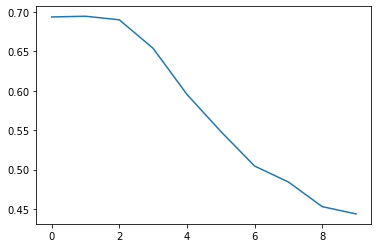

In [ ]:
plt.plot(train_loss)

In [ ]:
testiter = iter(testLoader)
images, 1 = testiter.next()

with torch.no_grad():
  images, labels = images.to(device), labels.to(device)
  pred = model(images)

images_np = [i.cpu() for i in images]
class_names = celeba_data.classes

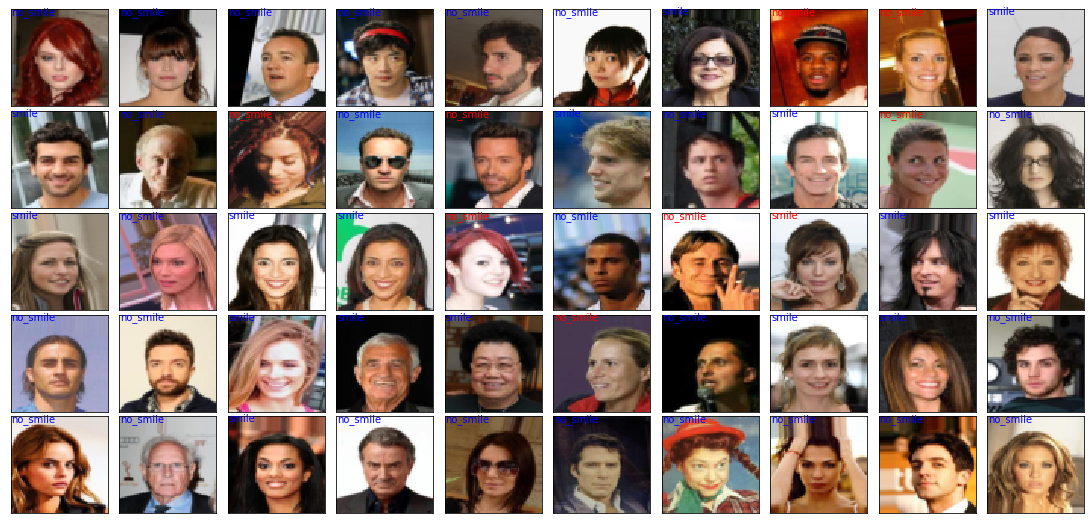

In [ ]:
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i].permute(1, 2, 0), cmap=plt.cm.gray_r, interpolation='nearest')

    if labels[i] == torch.max(pred[i], 0)[1]:
      ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='blue')
    else:
      ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='red')